**Sports v/s Politics Classification**

How to Run:

This notebook performs Sports vs Politics text classification using AG News dataset. From the original AG News dataset containing four categories (World, Sports, Business, and Sci/Tech), only the World and Sports classes were retained for this study. The World class was relabeled as Politics, and the remaining two categories were discarded.

1. Upload train.csv and test.csv
2. Run all cells
3. Evaluate models
4. Use custom input for prediction


Imports

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Dataset Loading

In [32]:
train_df = pd.read_csv("train.csv", header=0)
test_df = pd.read_csv("test.csv", header=0)

train_df.columns = ["label", "title", "description"]
test_df.columns = ["label", "title", "description"]

print(train_df.shape)
train_df.head()


(120000, 3)


,label,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Data Preprocessing

In [33]:
df = pd.concat([train_df, test_df], ignore_index=True)
print("Total samples:", df.shape[0])


Total samples: 127600


In [34]:
# Keep class 1 (World → Politics) and class 2 (Sports)
df = df[df["label"].isin([1, 2])]

# Rename labels
df["label"] = df["label"].map({1: "Politics", 2: "Sports"})

print(df["label"].value_counts())


label
Sports      31900
Politics    31900
Name: count, dtype: int64


In [35]:
df["text"] = df["title"] + " " + df["description"]

df = df[["text", "label"]]

df.head()


,text,label
448,"Phelps, Thorpe Advance in 200 Freestyle (AP) A...",Sports
449,Reds Knock Padres Out of Wild-Card Lead (AP) A...,Sports
450,"Dreaming done, NBA stars awaken to harsh Olymp...",Sports
451,"Indians Beat Twins 7-1, Nearing AL Lead (AP) A...",Sports
452,"Galaxy, Crew Play to 0-0 Tie (AP) AP - Kevin H...",Sports


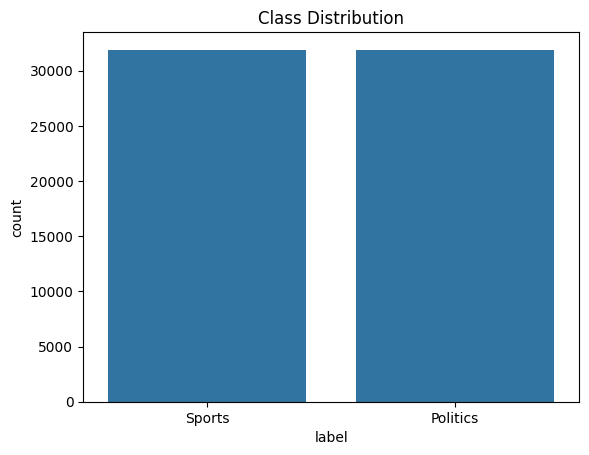

In [36]:
sns.countplot(x=df["label"])
plt.title("Class Distribution")
plt.show()


Train-Test Split


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


Model 1:
Feature Extraction using BoW + Naive bayes Classifier

In [38]:
bow = CountVectorizer(stop_words="english")

X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train_bow, y_train)

y_pred_nb = nb.predict(X_test_bow)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.9753918495297805
              precision    recall  f1-score   support

    Politics       0.99      0.96      0.98      6380
      Sports       0.97      0.99      0.98      6380

    accuracy                           0.98     12760
   macro avg       0.98      0.98      0.98     12760
weighted avg       0.98      0.98      0.98     12760



Model 2:
Feature Extraction using TF-IDF + Logistic Regression

In [39]:
tfidf = TfidfVectorizer(stop_words="english")

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

y_pred_lr = lr.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9773510971786834
              precision    recall  f1-score   support

    Politics       0.99      0.97      0.98      6380
      Sports       0.97      0.99      0.98      6380

    accuracy                           0.98     12760
   macro avg       0.98      0.98      0.98     12760
weighted avg       0.98      0.98      0.98     12760



Model 3:
Feature Extraction using TF-IDF + SVM Classifier

In [40]:
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9762539184952979
              precision    recall  f1-score   support

    Politics       0.98      0.97      0.98      6380
      Sports       0.97      0.98      0.98      6380

    accuracy                           0.98     12760
   macro avg       0.98      0.98      0.98     12760
weighted avg       0.98      0.98      0.98     12760



Accuracy Comparison Bar Plots (Across models)

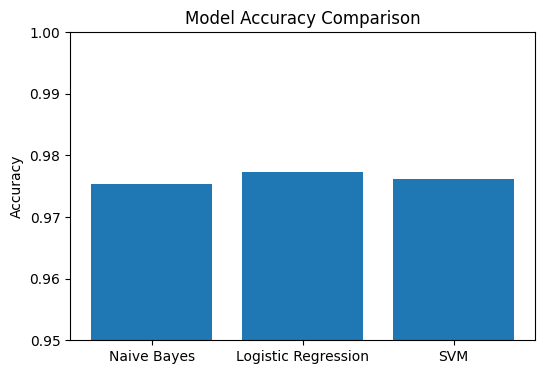

In [41]:
models = ['Naive Bayes', 'Logistic Regression', 'SVM']
accuracies = [0.9754, 0.9773, 0.9762]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0.95,1.0)
plt.show()


Confusion Matrix

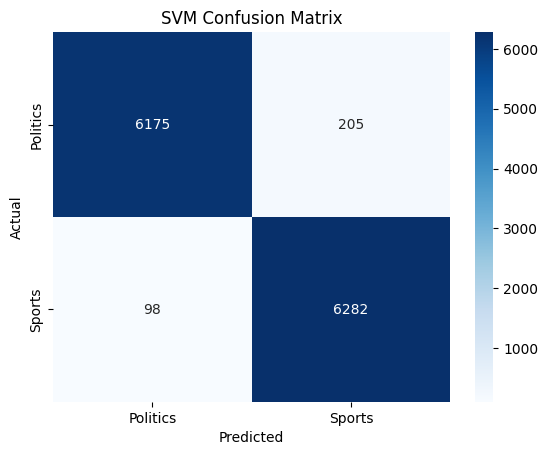

In [42]:
cm = confusion_matrix(y_test, y_pred_svm)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Politics", "Sports"],
            yticklabels=["Politics", "Sports"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()


Top Words - Both categories

In [43]:
feature_names = tfidf.get_feature_names_out()
lr_coef = lr.coef_[0]

top_sports_lr = lr_coef.argsort()[-20:]
top_politics_lr = lr_coef.argsort()[:20]

print("Top Sports Words (Logistic Regression):")
print([feature_names[i] for i in top_sports_lr])

print("\nTop Politics Words (Logistic Regression):")
print([feature_names[i] for i in top_politics_lr])


Top Sports Words (Logistic Regression):
['manchester', 'round', 'champion', 'club', 'manager', 'stadium', 'nba', 'games', 'baseball', 'player', 'olympic', 'game', 'players', '39', 'league', 'team', 'season', 'cup', 'sports', 'coach']

Top Politics Words (Logistic Regression):
['afp', 'iraq', 'president', 'minister', 'government', 'election', 'people', 'nuclear', 'iraqi', 'bush', 'military', 'said', 'arafat', 'presidential', 'political', 'eu', 'leader', 'prime', 'iran', 'war']


Custom Prediction Demo

In [44]:
def predict_text(text):
    # Transform using SAME TF-IDF vectorizer
    text_vector = tfidf.transform([text])

    # Predict
    prediction = lr.predict(text_vector)[0]

    return prediction


# Interactive mode
while True:
    user_input = input("Enter the text (or type 'exit'): ")

    if user_input.lower() == "exit":
        break

    result = predict_text(user_input)
    print("Predicted Category:", result)
    print()


Enter the text (or type 'exit'): The team secured a dramatic victory in the final over to win the championship title.
Predicted Category: Sports

Enter the text (or type 'exit'): The coach announced the playing eleven ahead of the crucial World Cup qualifier match.
Predicted Category: Sports

Enter the text (or type 'exit'): Parliament debated the economic impact of the proposed tax legislation.
Predicted Category: Politics

Enter the text (or type 'exit'): The government introduced a new policy aimed at reforming the national education system.
Predicted Category: Politics

Enter the text (or type 'exit'): The leader faced strong opposition during the final round of the campaign.
Predicted Category: Politics

Enter the text (or type 'exit'): The team met to discuss strategy before the decisive vote.
Predicted Category: Sports

Enter the text (or type 'exit'): The striker scored twice as the club advanced to the semifinals of the national league.
Predicted Category: Sports

Enter the te